<a href="https://colab.research.google.com/github/SuleymanToklu/Genetik-Optimizasyonu/blob/main/GenAlgoritma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-------------------------------------------------------
# Öğrenci Etüt Programı Optimizasyonu

**Adınız:** Süleyman

**Soyadınız:** Toklu

**Okul Numaranız:** 2112721029

**GitHub Repo Bağlantısı:** https://github.com/SuleymanToklu/Genetik-Optimizasyonu

-------------------------------------------------------

# Kütüphane ve Hiperparametreler Ekle

In [1]:
# numpy: Matematiksel işlemler ve özellikle diziler üzerinde hızlı işlem yapmak için.
# matplotlib: Sonuçları grafiğe dökmek için.
import numpy as np
import matplotlib.pyplot as plt

# Tekrarlanabilirliği sağlamak için rastgele tohum.
np.random.seed(42)

polulasyonBuyuklugu = 50 # Her nesilde kaç farklı çözüm adayı yarışacak?
kusakSayisi = 100 #  Bu evrim süreci kaç kuşak sürecek?
caprazlamaOrani = 0.8 # Genetik çeşitlilik olması için crossover belirlenir.
genBozuklukOrani = 0.1 # Çeşitlilik olsun diye genlerin bozulma ihtimali belirlenir.
calismaSaati = [0, 10] # Çalışma saati en az 0, en fazla 10 olabilir. Bu sınırı baştan çiziyoruz.

# Fonksiyonlar ve Genetik Algoritması

In [5]:
# Genetik algoritmanın en iyilenmesi için gerekli fonksiyonların kurucu metodu oluşturulur.
class OgrenciEnIyileyiciGenetikAlgoritma:
    def __init__(self, polulasyonBuyuklugu, kusakSayisi, caprazlamaOrani, mutasyonOrani, calismaSaati): # Yukarıda varsayılan olarak ayarladığımız hiperparametleri kullanıyoruz.
        self.polulasyonBuyuklugu = polulasyonBuyuklugu
        self.kusakSayisi = kusakSayisi
        self.caprazlamaOrani = caprazlamaOrani
        self.mutasyonOrani = mutasyonOrani
        self.calismaSaati = calismaSaati
        self.genSayisi = 2
        self.gecmis = []

# Genetik algoritma için problemde verilen fonksiyon
    def AmacFonk(self, x1, x2):
        return 4*x1 + 5*x2 - 0.5*(x1**2) - 0.2*(x2**2) # y = 4x₁ + 5x₂ - 0.5x₁² - 0.2x₂²

# Ceza mekanizması problemin temelindeki kısıtlarımız eğer toplam süre 12 saati geçerse veya Fen dersi 2 saatin altına düşerse, sisteme bir ceza puanı döndürür.
    def Ceza(self, x1, x2):
        ceza = 0
        toplamSure = x1 + x2

        if toplamSure > 12:
            ceza += (toplamSure - 12) * 50
        if x2 < 2:
            ceza += (2 - x2) * 50
        return ceza

# Uygunluk Hesaplama: Gerçek başarı puanı burada çıkar. Formül: (Amaç Fonksiyonu Skoru) - (Ceza Puanı). Eğer kısıtları ihlal eden bir çözümse, puanı eksiye düşer ve seçilme şansı kalmaz.
    def FitnessHesabi(self, birey):
        x1, x2 = birey[0], birey[1]
        score = self.AmacFonk(x1, x2)
        ceza = self.Ceza(x1, x2)
        return score - ceza

# Birey Oluşturma: Rastgele iki sayı üretir (Matematik ve Fen için) ve bu sayılar 0 ile 10 arasındadır.
    def KisiOlustur(self):
        return np.random.uniform(self.calismaSaati[0], self.calismaSaati[1], self.genSayisi)

# Turnuva Yöntemi: Popülasyondan rastgele 3 kişiyi seçer, fitness puanlarına bakar. En yüksek puanı alan "ebeveyn" olmaya hak kazanır. Bunu yapmazsak sadece şanslılar değil, "iyi genli" olanlar ürer.
    def Secim(self, populasyon, fitnessSkoru):
        ebeveyn = []
        for _ in range(self.polulasyonBuyuklugu):
            endeksler = np.random.randint(0, self.polulasyonBuyuklugu, 3)
            adaylar = populasyon[endeksler]
            aday_fitness = fitnessSkoru[endeksler]
            best_idx = np.argmax(aday_fitness)
            ebeveyn.append(adaylar[best_idx])
        return np.array(ebeveyn)

# Çaprazlama: İki ebeveynin genlerini sayısal olarak karıştırır. Babanın saatinin %50'si ile Annenin saatinin %50'sini toplayıp çocuğa verir ve çocuk anne-babaya benzer ama aynısı olmaz.
    def Caprazlama(self, ebeveyn1, ebeveyn2):
        if np.random.rand() < self.caprazlamaOrani:
            alpha = 0.5
            cocuk1 = alpha * ebeveyn1 + (1 - alpha) * ebeveyn2
            cocuk2 = alpha * ebeveyn2 + (1 - alpha) * ebeveyn1
            return cocuk1, cocuk2
        return ebeveyn1.copy(), ebeveyn2.copy()

# Mutasyon: Bazen rastgelelik gerekir. Bireyin çalışma saatine çok ufak bir sayı ekler veya çıkarır.Bu işlem algoritmanın yerel maksimuma takılıp kalmasını engeller. Biraz da Şans faktörü.
    def Mutasyon(self, birey):
        if np.random.rand() < self.mutasyonOrani:
            idx = np.random.randint(0, self.genSayisi)
            gurultu = np.random.normal(0, 0.5)
            birey[idx] += gurultu
            birey[idx] = np.clip(birey[idx], self.calismaSaati[0], self.calismaSaati[1])
        return birey

# Önce rastgele bir ilk popülasyon yaratır. Sonra 100 jenerasyon boyunca şu döngüyü kurar:
# - Herkesin puanını hesapla.En iyiyi kaydet.Turnuva ile anne-baba seç. Çaprazla ve mutasyona uğrat. Eski popülasyonu sil, yerine çocukları koy.
    def run(self):
        populasyon = np.array([self.KisiOlustur() for _ in range(self.polulasyonBuyuklugu)]) # Belirlediğimiz sınırlar içinde tamamen rastgele değerlerden oluşan ilk öğrenci grubunu oluşturuyoruz.
        enIyiSonuc = None
        enIyiFitness = -np.inf

        for gen in range(self.kusakSayisi): # Evrimi başlatan ana döngü. Belirlediğimiz kuşak sayısı 100`e kadar çalışıyor.
            fitnessSkoru = np.array([self.FitnessHesabi(ind) for ind in populasyon])

            anlikEnIyiIdx = np.argmax(fitnessSkoru)
            anlikFitness = fitnessSkoru[anlikEnIyiIdx]
            self.gecmis.append(anlikFitness)

            if anlikFitness > enIyiFitness:
                enIyiFitness = anlikFitness
                enIyiSonuc = populasyon[anlikEnIyiIdx]

            ebeveynler = self.Secim(populasyon, fitnessSkoru)

            sonrakiKusak = []
            for i in range(0, self.polulasyonBuyuklugu, 2):
                e1 = ebeveynler[i]
                e2 = ebeveynler[i+1] if (i+1) < self.polulasyonBuyuklugu else ebeveynler[0]

                c1, c2 = self.Caprazlama(e1, e2)
                sonrakiKusak.append(self.Mutasyon(c1))
                sonrakiKusak.append(self.Mutasyon(c2))

            populasyon = np.array(sonrakiKusak[:self.polulasyonBuyuklugu])

        return enIyiSonuc, enIyiFitness

# Programın Çalışması, Görselleştirme ve Sonuçların Çıktıları

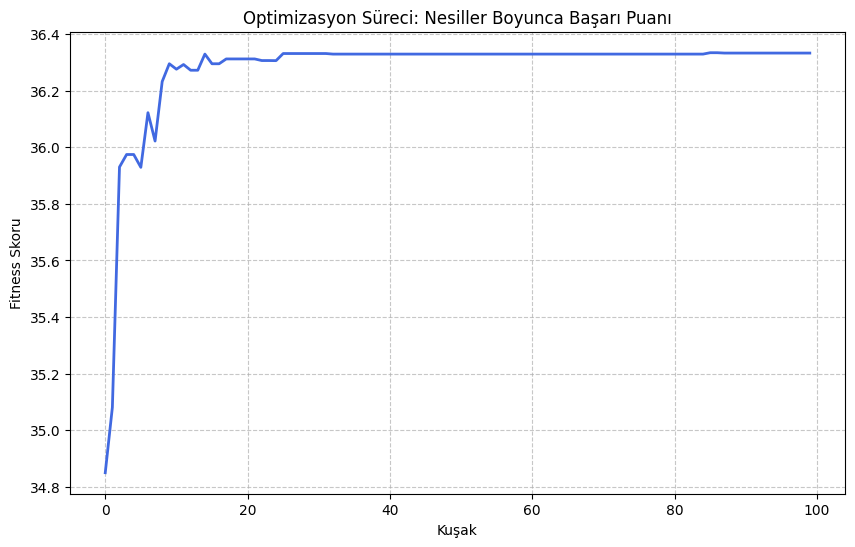

Optimizasyon Sonucu
Matematik Süresi (x1) : 2.8918 saat
Fen Süresi (x2)       : 9.1074 saat
Toplam Süre           : 11.9992 saat
Hesaplanan Başarı Puanı: 36.3340

--- Dogrulama ---
Kısıt 1 (x1+x2 <= 12): Geçti
Kısıt 2 (x2 >= 2)    : Geçti


In [6]:
# Programın Çalışması

ga = OgrenciEnIyileyiciGenetikAlgoritma(polulasyonBuyuklugu, kusakSayisi, caprazlamaOrani, genBozuklukOrani, calismaSaati)
enIyiSonuc, enIyiSkor = ga.run()

# Görselleştirme

plt.figure(figsize=(10, 6))
plt.plot(ga.gecmis, linewidth=2, color='royalblue')
plt.title('Optimizasyon Süreci: Nesiller Boyunca Başarı Puanı')
plt.xlabel('Kuşak')
plt.ylabel('Fitness Skoru')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Sonuçların Çıktıları

x1_final, x2_final = enIyiSonuc
print(f"{'='*30}")
print(f"Optimizasyon Sonucu")
print(f"{'='*30}")
print(f"Matematik Süresi (x1) : {x1_final:.4f} saat")
print(f"Fen Süresi (x2)       : {x2_final:.4f} saat")
print(f"Toplam Süre           : {x1_final + x2_final:.4f} saat")
print(f"Hesaplanan Başarı Puanı: {enIyiSkor:.4f}")
print(f"\n--- Dogrulama ---")
print(f"Kısıt 1 (x1+x2 <= 12): {'Geçti' if (x1_final+x2_final) <= 12.01 else 'Kaldı'}")
print(f"Kısıt 2 (x2 >= 2)    : {'Geçti' if x2_final >= 1.99 else 'Kaldı'}")